## <center>Bangla Handwritten Math Solver<center> 

## Importing Libraries

In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours

## Loading the Dataset 

In [2]:
x = []
y = []
datadir = 'dataset'
for folder in os.listdir(datadir):
    print(folder + '....')
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

0....
1....
2....
3....
4....
5....
6....
7....
8....
9....
add....
div....
mul....
sub....
9062
9062
labels : ['4', 'mul', '9', '8', '1', '6', '3', '7', '0', '5', 'sub', '2', 'div', 'add']


## Visualizing Images in the Dataset 

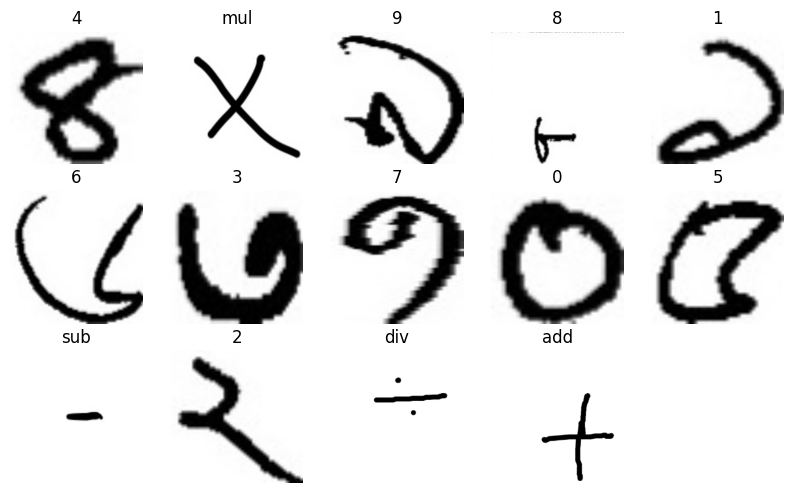

In [3]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

## Data Distribution of the Dataset 

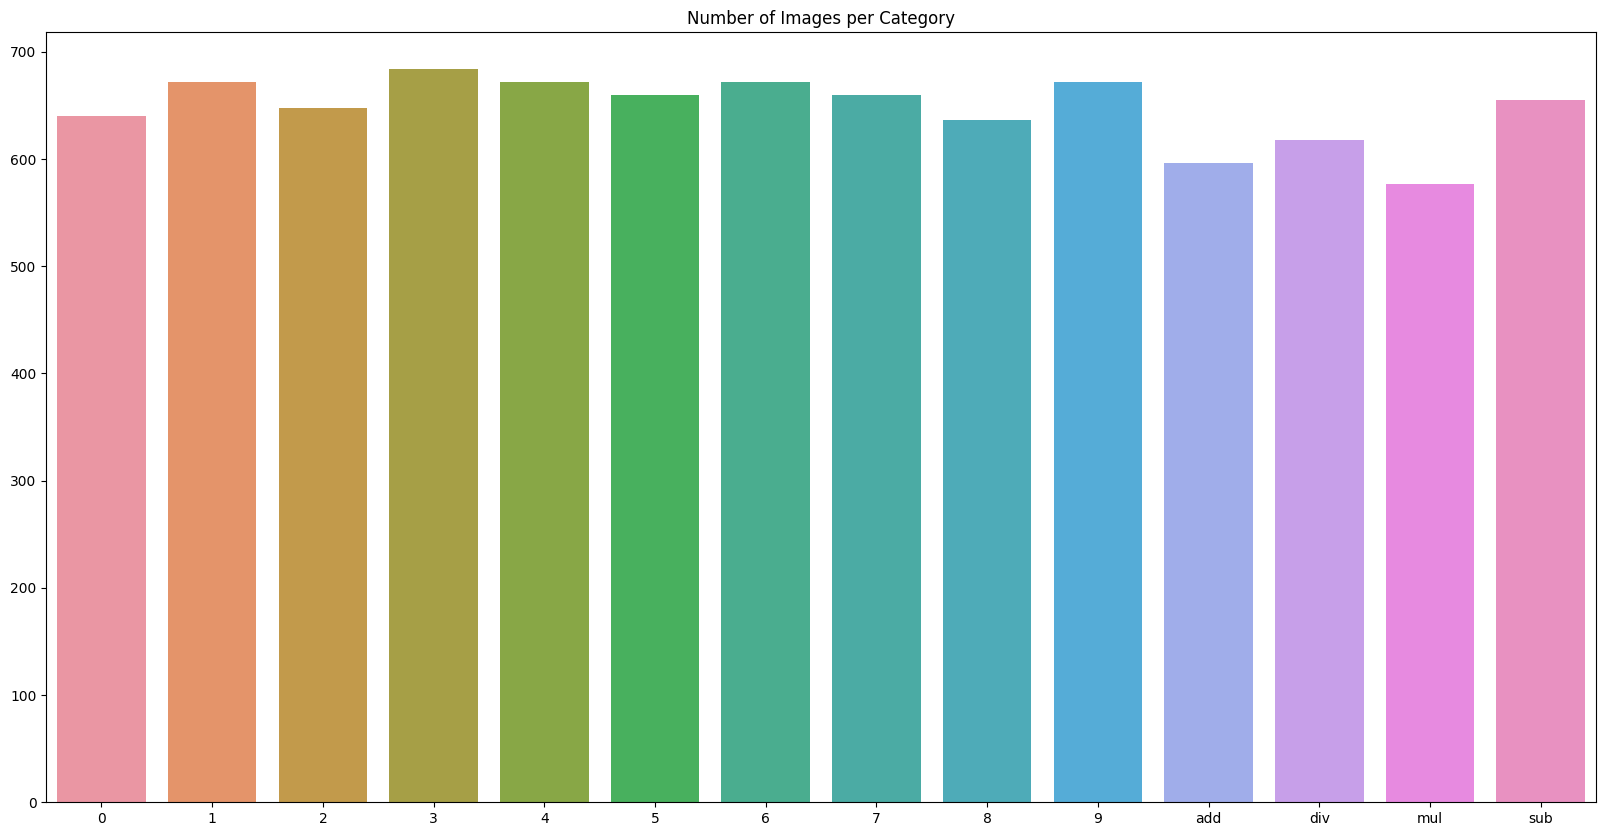

In [4]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique, y=count).set_title('Number of Images per Category')
plt.show()

In [5]:
# the dataset is not much imbalanced. So balancing is not required here much.

## Preprocessing the Data

In [6]:
X = []
for i in range(len(x)):
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

9062


In [7]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

9062


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

print(len(Y_train))
print(len(Y_test))

7249
1813
7249
1813


## Data Distribution in Train

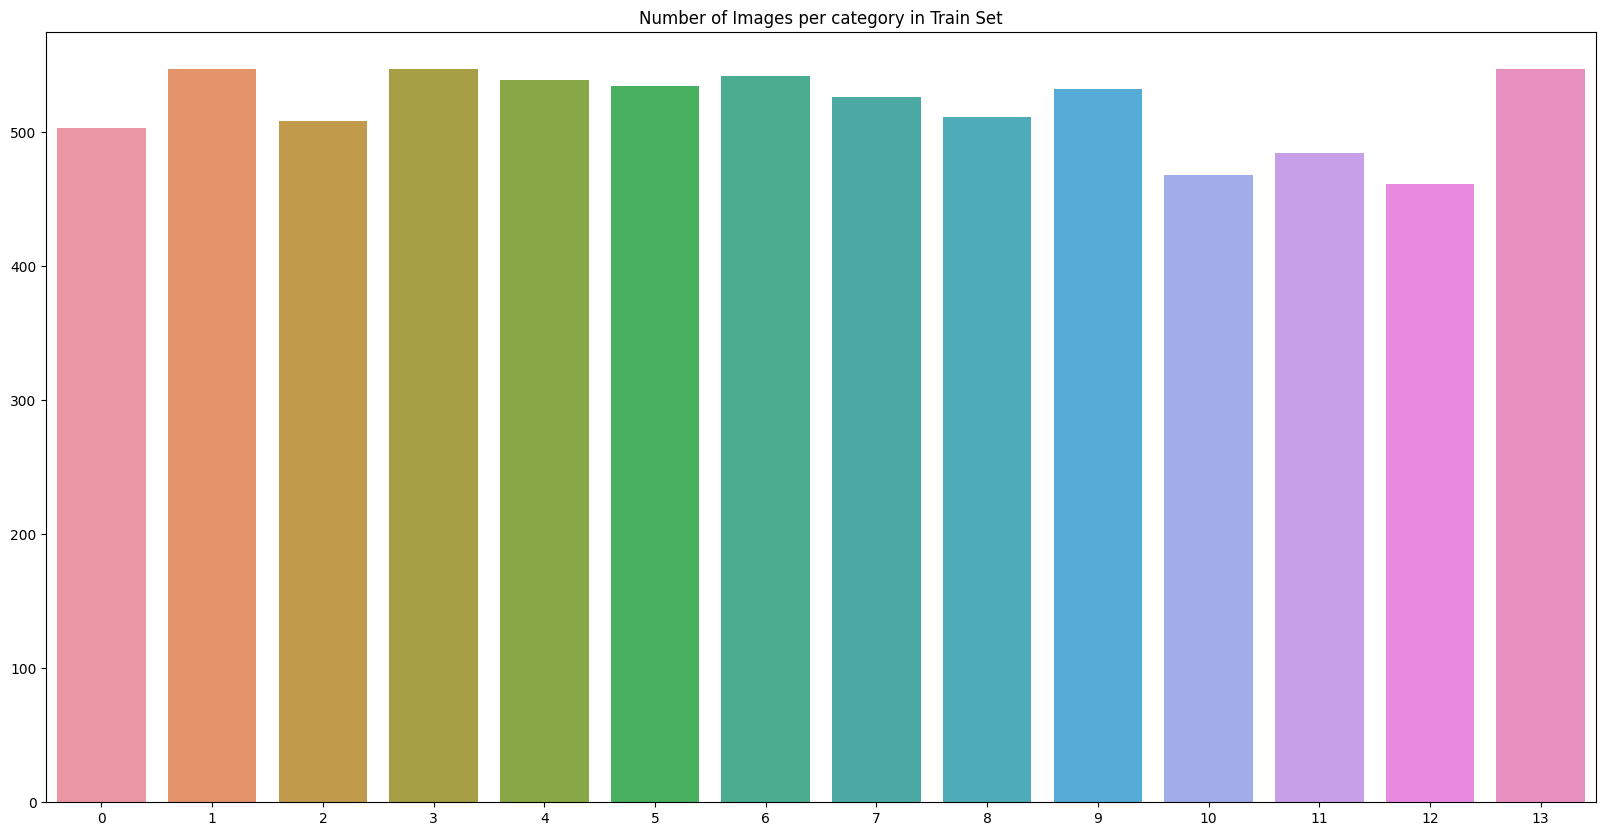

In [9]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_train, y=count_train).set_title('Number of Images per category in Train Set')
plt.show()

## Data Distribution in Test Set

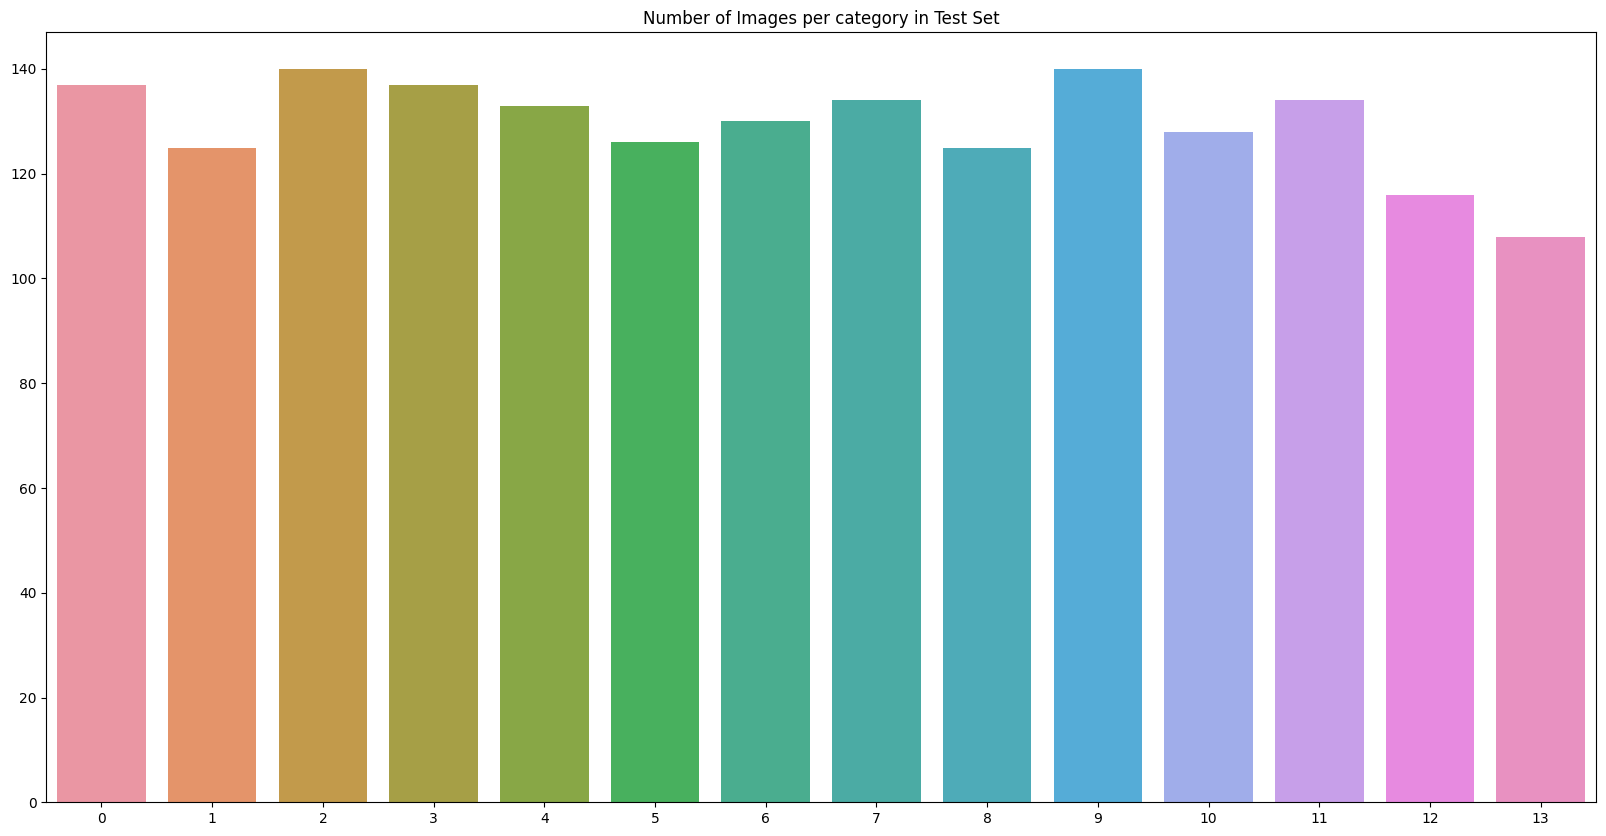

In [10]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_test, y=count_test).set_title('Number of Images per category in Test Set')
plt.show()

## Defining the Model 

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7249, 32, 32, 1)
(1813, 32, 32, 1)
(7249, 14)
(1813, 14)


In [12]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [13]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

##  Training the Model

In [14]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('math_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

In [15]:
aug = ImageDataGenerator(zoom_range=0.1,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
57/57 [==============================] - 10s 155ms/step - loss: 2.9988 - accuracy: 0.3664 - val_loss: 1.8288 - val_accuracy: 0.7148
Epoch 2/100
57/57 [==============================] - 9s 154ms/step - loss: 1.2171 - accuracy: 0.7676 - val_loss: 1.0874 - val_accuracy: 0.8263
Epoch 3/100
57/57 [==============================] - 8s 143ms/step - loss: 0.8566 - accuracy: 0.8255 - val_loss: 0.9764 - val_accuracy: 0.8389
Epoch 4/100
57/57 [==============================] - 8s 144ms/step - loss: 0.7177 - accuracy: 0.8427 - val_loss: 0.7902 - val_accuracy: 0.8571
Epoch 5/100
57/57 [==============================] - 9s 157ms/step - loss: 0.6226 - accuracy: 0.8655 - val_loss: 0.6854 - val_accuracy: 0.8825
Epoch 6/100
57/57 [==============================] - 9s 157ms/step - loss: 0.5616 - accuracy: 0.8778 - val_loss: 0.6517 - val_accuracy: 0.8836
Epoch 7/100
57/57 [==============================] - 7s 120ms/step - loss: 0.5059 - accuracy: 0.8903 - val_loss: 0.6135 - val_accuracy: 0.886

Epoch 58/100
57/57 [==============================] - 7s 126ms/step - loss: 0.1433 - accuracy: 0.9699 - val_loss: 0.1904 - val_accuracy: 0.9636
Epoch 59/100
57/57 [==============================] - 8s 139ms/step - loss: 0.1339 - accuracy: 0.9713 - val_loss: 0.1771 - val_accuracy: 0.9658
Epoch 60/100
57/57 [==============================] - 7s 126ms/step - loss: 0.1393 - accuracy: 0.9706 - val_loss: 0.1601 - val_accuracy: 0.9691
Epoch 61/100
57/57 [==============================] - 7s 127ms/step - loss: 0.1352 - accuracy: 0.9703 - val_loss: 0.1836 - val_accuracy: 0.9608
Epoch 62/100
57/57 [==============================] - 7s 126ms/step - loss: 0.1388 - accuracy: 0.9714 - val_loss: 0.1557 - val_accuracy: 0.9680
Epoch 63/100
57/57 [==============================] - 7s 125ms/step - loss: 0.1329 - accuracy: 0.9714 - val_loss: 0.1512 - val_accuracy: 0.9691
Epoch 64/100
57/57 [==============================] - 8s 141ms/step - loss: 0.1306 - accuracy: 0.9723 - val_loss: 0.1708 - val_accuracy:

##  Loss and Accuracy Plot

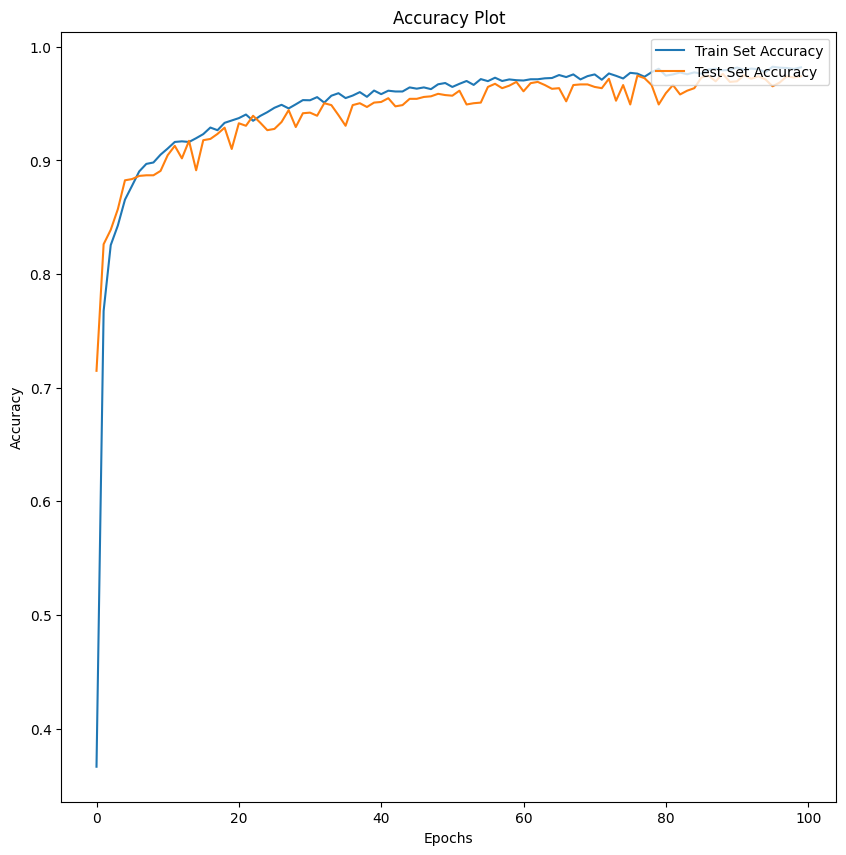

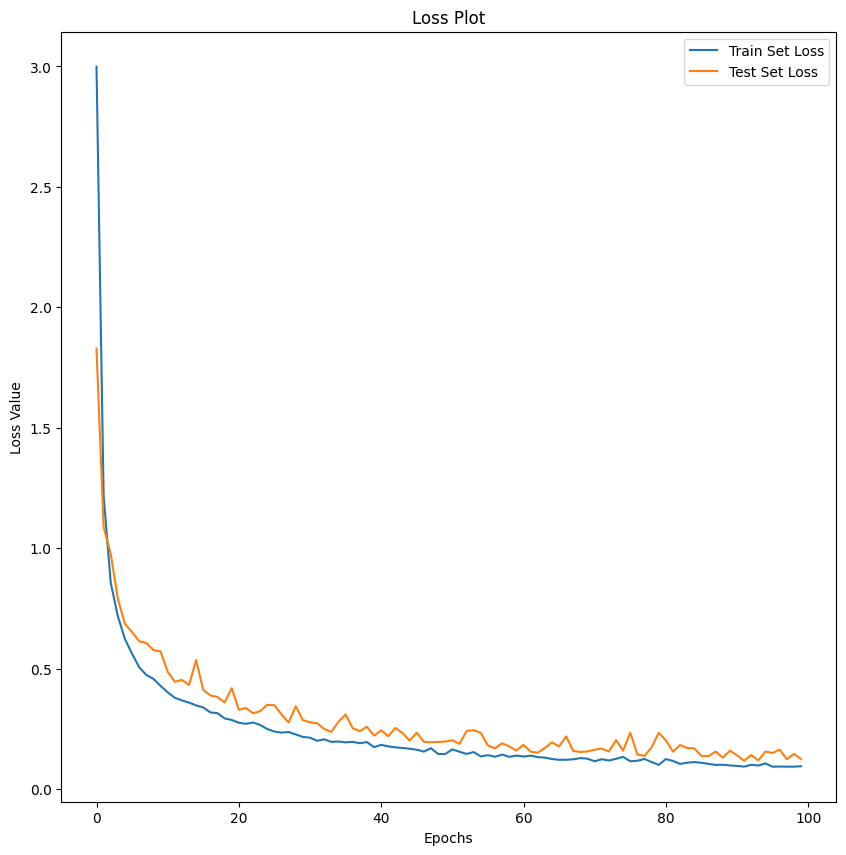

In [16]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

## Confusion Matrix 

57/57 [==============================] - 1s 7ms/step


<AxesSubplot: >

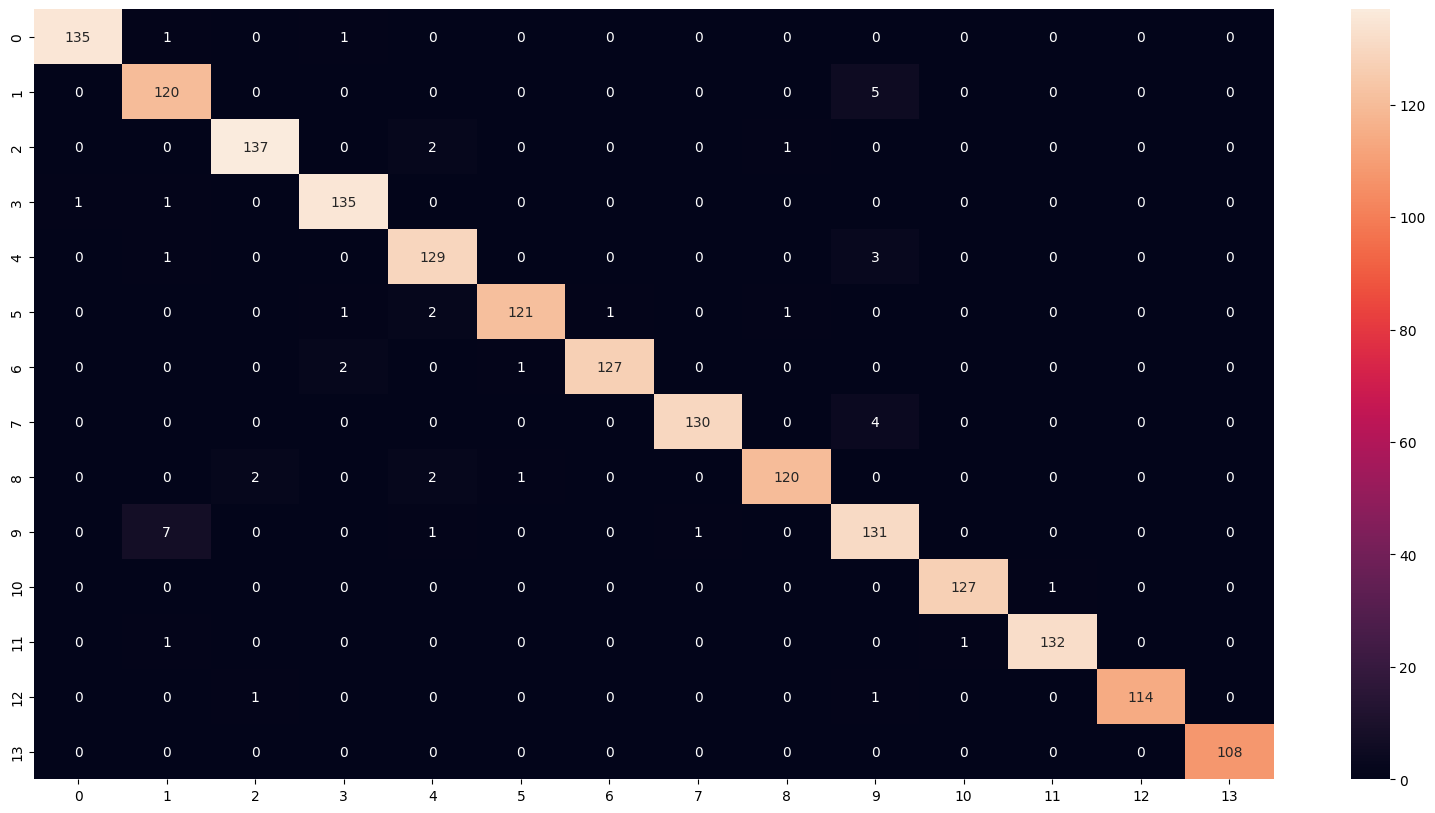

In [17]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)

matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
figure = plt.figure(figsize=(20, 10))
sb.heatmap(df_cm, annot=True, fmt='d')

## Classification Report

In [18]:
print(classification_report(Y_test_hat, ypred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       137
           1       0.92      0.96      0.94       125
           2       0.98      0.98      0.98       140
           3       0.97      0.99      0.98       137
           4       0.95      0.97      0.96       133
           5       0.98      0.96      0.97       126
           6       0.99      0.98      0.98       130
           7       0.99      0.97      0.98       134
           8       0.98      0.96      0.97       125
           9       0.91      0.94      0.92       140
          10       0.99      0.99      0.99       128
          11       0.99      0.99      0.99       134
          12       1.00      0.98      0.99       116
          13       1.00      1.00      1.00       108

    accuracy                           0.97      1813
   macro avg       0.98      0.97      0.97      1813
weighted avg       0.97      0.97      0.97      1813



## Saving the Model 

In [19]:
model.save('math_symbol_and_digit_recognition.h5')

## Testing the Model 

In [20]:
def test_pipeline(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 23ms/step


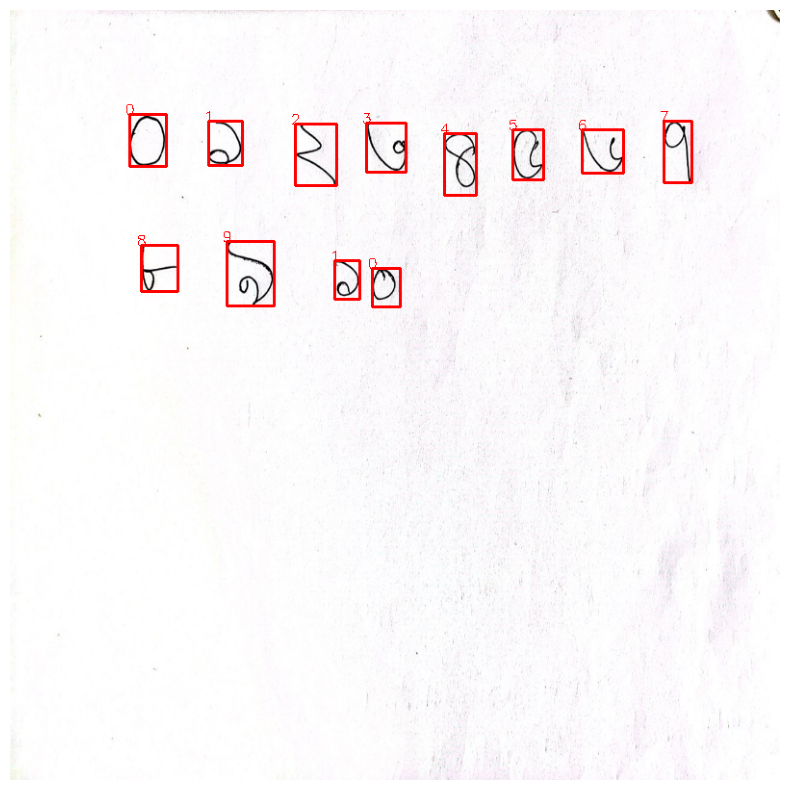

In [21]:
test_pipeline('test_data/test.jpg')

1/1 [==============================] - 0s 22ms/step


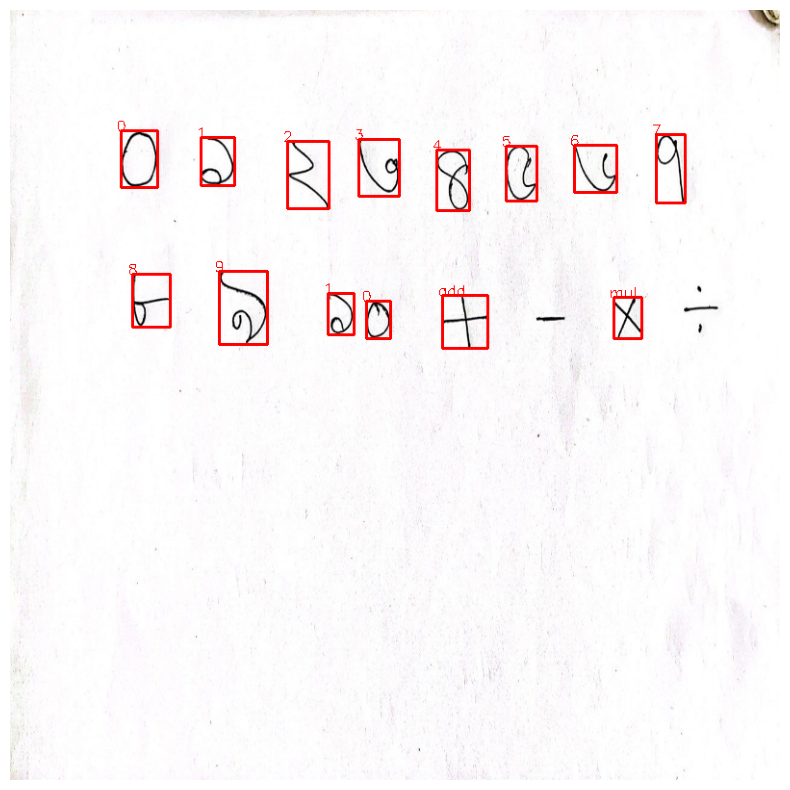

In [22]:
test_pipeline('test_data/test_2.jpg')

In [23]:
def test_pipeline_equation(image_path):
    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            chars.append(label)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    e = ''
    for i in chars:
        if i=='add':
            e += '+'
        elif i=='sub':
            e += '-'
        elif i=='mul':
            e += '*'
        elif i=='div':
            e += '/'
        else:
            e += i
    v = eval(e)
    print('Value of the expression {} : {}'.format(e, v)) 

1/1 [==============================] - 0s 25ms/step


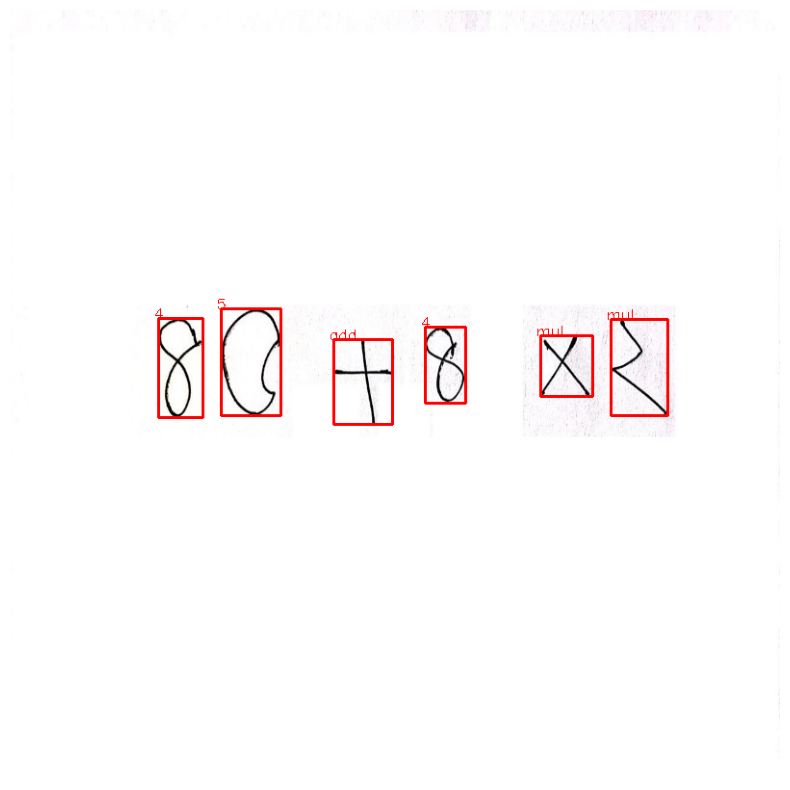

SyntaxError: unexpected EOF while parsing (<string>, line 1)

In [25]:
test_pipeline_equation('test_data/test_equation_3.jpg')

## <center>Bangla Handwritten Digit Recognition [2]<center> 

## Import Necessary Libraries

In [ ]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader,Dataset
from tqdm.notebook import trange
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

## Analyze the Dataset

In [ ]:
folders = glob.glob('dataset/**')
len(folders)
folders

In [ ]:
files = glob.glob("dataset/**/*.jpg") 
print("Size of the dataset: {}".format(len(files)))

In [ ]:
lens = []
for folder_path in folders:
  files = glob.glob(os.path.join(folder_path, '*.jpg'))
  lens.append(len(files))
    
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub'] 
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(lens, labels=numbers, startangle=90, autopct='%1.1f%%')
plt.show()

## Read the Data

In [ ]:
def read_data(data_dir='dataset'):
    data = []
    labels = []
    for data_type in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']:
        digit = data_type[-1]
        path = os.path.join(data_dir, data_type, '*.jpg')
        files = glob.glob(path)
        for f in files:
            data.append(f)
            labels.append(digit)
    assert len(data) == len(labels), "{}/{} Data size does not match labels size".format(len(data), len(labels))
    return data, labels


source_dir = 'dataset'
data, labels = read_data(source_dir)
assert len(data) == len(labels), "Number of image files do not match number of labels!"

df = pd.DataFrame(list(zip(data, labels)), columns =['file', 'label'])
df.head()

## Split Data into Train-Validation-Test Subsets

In [ ]:
def split_data(df, tsize=0.2):
    ''' Split the dataset into train-test subsets '''
    train, test = train_test_split(df, test_size=tsize, shuffle=True, stratify=df.label, random_state=123)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    return train, test

train, test_subset = split_data(df, tsize=0.2)
train_subset, val_subset = split_data(train, tsize=0.1)

print("Total Training Examples: {}".format(len(train_subset)))
print("Total Validation Examples: {}".format(len(val_subset)))
print("Total Test Examples: {}".format(len(test_subset)))

## Create a Custom Bengali Dataset Class

In [ ]:
class BengaliDigitDataset(Dataset):
    
    def __init__(self, df, transform, width=28, height=28):
        self.df = df
        self.transform = transform
        self.files = df['file']
        self.labels = df['label']
        self.width = width
        self.height = height

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img = cv2.imread(self.files.iloc[index], cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(self.height, self.width), interpolation=cv2.INTER_AREA)
        img = self.transform(img)
        label = self.labels[index]
        return img,label

## Process the Data

In [ ]:
def prepocess_data(data_input, width, height):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    data_processed = BengaliDigitDataset(data_input, transform, width, height)
    return data_processed

width = 28
height = 28
train_pr = prepocess_data(train_subset, width, height)
val_pr = prepocess_data(val_subset, width, height)
test_pr = prepocess_data(test_subset, width, height)

In [ ]:
image, label = train_pr[0]

print(image.shape) 

image = image.numpy().transpose((1, 2, 0))
plt.imshow(image)

print(label)

## Load the Data

In [ ]:
batch_size = 4000
seed = 123
random.seed(seed) 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

train_dataloader = DataLoader(train_pr, batch_size, shuffle=True)
val_dataloader = DataLoader(val_pr, batch_size, shuffle=False)
test_dataloader = DataLoader(test_pr, batch_size, shuffle=False)

## Define the Model Architecture

In [ ]:
class BengaliDigitClassifier(nn.Module):
    def __init__(self, input_dim=2352, output_dim=10, hidden_1=32, hidden_2=32, dropout_frc=0.2):
        super(BengaliDigitClassifier, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_1)
        self.hidden_layer = nn.Linear(hidden_1, hidden_2)
        self.output_layer = nn.Linear(hidden_2, output_dim)
        self.dropout_layer = nn.Dropout(dropout_frc)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        h1 = F.relu(self.input_layer(x))
        h1 = self.dropout_layer(h1)
        h2 = F.relu(self.hidden_layer(h1))
        h2 = self.dropout_layer(h2)
        y_pred = self.output_layer(h2)
        return y_pred

## Build the Model

In [ ]:
num_channels = 3
num_classes = 14
input_dim = int(num_channels * height * width)
output_dim = int(num_classes)
learning_rate = 0.003
n_epochs = 100

model = BengaliDigitClassifier(input_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #train on gpu if available
print("Using device {}.\n".format(device))
model = model.to(device)
criterion = criterion.to(device)
    
print(model)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_parameters(model)
print("The model has total {} trainable parameters".format(num_params))

## Train the Model

In [ ]:
def eval_metric(predictions, labels):
    max_predictions = predictions.argmax(axis=1, keepdim=True) 
    avg_acc = round(accuracy_score(y_true=labels.to('cpu').tolist(), y_pred=max_predictions.detach().cpu().numpy()), 2)*100
    return avg_acc

def train_fn(model, train_loader, criterion, optimizer, device):
    model.train() 
    total_loss, total_acc = 0, 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        batch_y_pred = model(batch_x)
        loss = criterion(batch_y_pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += eval_metric(batch_y_pred, batch_y)
    
    loss_per_epoch = total_loss/len(train_loader)
    acc_per_epoch = total_acc/len(train_loader)
    return loss_per_epoch, acc_per_epoch

def eval_fn(model, data_loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0, 0
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_pred = model(batch_x) 
            loss = criterion(batch_y_pred, batch_y) 
            total_loss += loss.item()
            total_acc += eval_metric(batch_y_pred, batch_y)
    
    loss_per_epoch = total_loss/len(data_loader)
    acc_per_epoch = total_acc/len(data_loader)
    return loss_per_epoch, acc_per_epoch

In [ ]:
train_losses, validation_losses = [], []
train_accuracies, validation_accuracies = [], []
best_val_loss = float('inf')

for epoch in range(n_epochs):
    
    train_loss_per_epoch, train_acc_per_epoch = train_fn(model, train_dataloader, criterion, optimizer, device)
    val_loss_per_epoch, val_acc_per_epoch = eval_fn(model, val_dataloader, criterion, device)

    train_losses.append(train_loss_per_epoch)
    validation_losses.append(val_loss_per_epoch)
    train_accuracies.append(train_acc_per_epoch)
    validation_accuracies.append(val_acc_per_epoch)

    if val_loss_per_epoch < best_val_loss:
        best_val_loss = val_loss_per_epoch
        torch.save(model.state_dict(), 'math_symbol_and_digit_recognition.pt')

    print("Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.2f}%".format(epoch, train_loss_per_epoch, train_acc_per_epoch))
    print("Epoch: {}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%\n".format(epoch, val_loss_per_epoch, val_acc_per_epoch))

## Plot Training and Validation Losses over all Epochs

In [ ]:
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, validation_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plot Training and Validation Accuracies over all Epochs

In [ ]:
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epochs, validation_accuracies, 'm', label='Validation Accuracy')
plt.title('Average Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate the Model on Test Data

In [ ]:
model.load_state_dict(torch.load('digits_recognition.pt'))
test_loss, test_accuracy = eval_fn(model, test_dataloader, criterion, device)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy))

## Confusion Matrix

In [ ]:
def predict(model, data_loader, device):
    model.eval()
    probs, labels = [], []   
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)    
            batch_y_pred = model(batch_x)
            batch_y_prob = F.softmax(input=batch_y_pred, dim=-1)
            max_prob = batch_y_prob.argmax(axis=1, keepdim=True)
            max_prob = torch.squeeze(max_prob)
            probs.append(max_prob.detach().cpu().numpy())
            labels.append(batch_y.to('cpu').tolist())  
    return np.concatenate(probs, axis=0), np.concatenate(labels, axis=0)

def plot(predictions, labels):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, predictions)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Greens', ax=ax)
    

predictions, labels = predict(model, test_dataloader, device)
plot(predictions, labels)